## RetinaNet 模型训练 

In [1]:
# !wget https://pinlandata.blob.core.windows.net/pinlan-data-hub/%E5%A4%96%E5%8C%85%E9%87%87%E9%9B%86/0523%E6%A3%80%E6%B5%8B%E6%95%B0%E6%8D%AE/detdata_baijiu_train.zip

In [2]:
# !mv detdata_baijiu_train.zip data/

In [3]:
# !unzip data/detdata_baijiu_train.zip

## 划分数据集

In [4]:
data_dir = 'data/baijiu'
result_model_path = 'models/'
ratio = 0.1

In [5]:
import os
import subprocess

# 开始运行程序
# 数据准备
data_prep_command_line = ['python', 'data_prep/split_data.py', '--data_dir', data_dir, '--ratio', str(ratio),]
print('\n开始分离训练集和验证集')
process = subprocess.Popen(data_prep_command_line)
process.wait()
if process.returncode != 0:
    print(f"分离训练集和验证集失败，失败码：{process.returncode}")
else:
    print('分离训练集和验证集成功')


开始分离训练集和验证集
分离训练集和验证集成功


In [6]:
#!python data_prep/split_data.py --data_dir data/baijiu --ratio 0.1

## 生成CSV格式数据集和标注

In [7]:
# 生成 csv
gen_csv_command_line = ['python', 'data_prep/gen_csv.py', '--data_dir', data_dir,]
print('\n开始生成 csv 文件')
process = subprocess.Popen(gen_csv_command_line)
process.wait()
if process.returncode != 0:
    print(f"生成 csv 文件失败，失败码：{process.returncode}")
else:
    print('生成 csv 文件成功')


开始生成 csv 文件
生成 csv 文件成功


In [8]:
# !python data_prep/gen_csv.py --data_dir data/baijiu

## 训练模型

In [ ]:
# 训练模型
train_csv_path = os.path.join(data_dir, 'train_data.csv')
val_csv_path = os.path.join(data_dir, 'val_data.csv')
class_csv_path = os.path.join(data_dir, 'class.csv')
train_log_path = 'logs/train_info.txt'

if os.path.exists(train_log_path):
    os.remove(train_log_path)
    
train_log = open(train_log_path, 'a')

train_command_line = ['python', 'keras-retinanet/keras-retinanet/keras_retinanet/bin/train.py', '--snapshot-path', result_model_path, 'csv', train_csv_path, class_csv_path, '--val-annotations', val_csv_path]
print('\n开始训练...')
process = subprocess.Popen(train_command_line, stdout=train_log, stderr=train_log)
process.wait()
if process.returncode != 0:
    print(f"训练失败，失败码：{process.returncode}")
else:
    print('训练完成!')


开始训练...


In [ ]:
# !python keras-retinanet/keras_retinanet/bin/train.py --snapshot-path models csv data/baijiu/train_data.csv data/baijiu/class.csv --val-annotations data/baijiu/val_data.csv

## 转换前向模型

In [22]:
trained_model_path = 'models/resnet50_csv_06.h5'
inference_model_save_path = "models/RetinaNet/retinanet_inference.h5"

In [25]:
import subprocess

convert_command = ['python', 'keras-retinanet/keras-retinanet/keras_retinanet/bin/convert_model.py', '--no-class-specific-filter', trained_model_path, inference_model_save_path]
print('开始模型转换...')
process = subprocess.Popen(convert_command)
process.wait()
if process.returncode != 0:
    print(f"模型转换失败，失败码：{process.returncode}")
else:
    print('模型转换成功!')

开始模型转换...
模型转换成功!


## 使用 GPU 推理

In [26]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1 Physical GPUs, 1 Logical GPUs


## 加载类别标注

In [27]:
!pip install pandas

In [28]:
import pandas as pd

df = pd.read_csv("data/baijiu/class.csv", header=None)

# load label to names mapping for visualization purposes
labels_to_names = df[0].values.tolist()

In [29]:
df[0].values.tolist()

['box', 'others', 'bottle', 'bag', 'jar', 'bucket']

## 加载 RetinaNet 模型

In [30]:
model = models.load_model(inference_model_save_path, backbone_name='resnet50')

# print(model.summary())

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

/home/ysdz/anaconda3/envs/new3/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 测试单张效果

processing time:  4.121702432632446


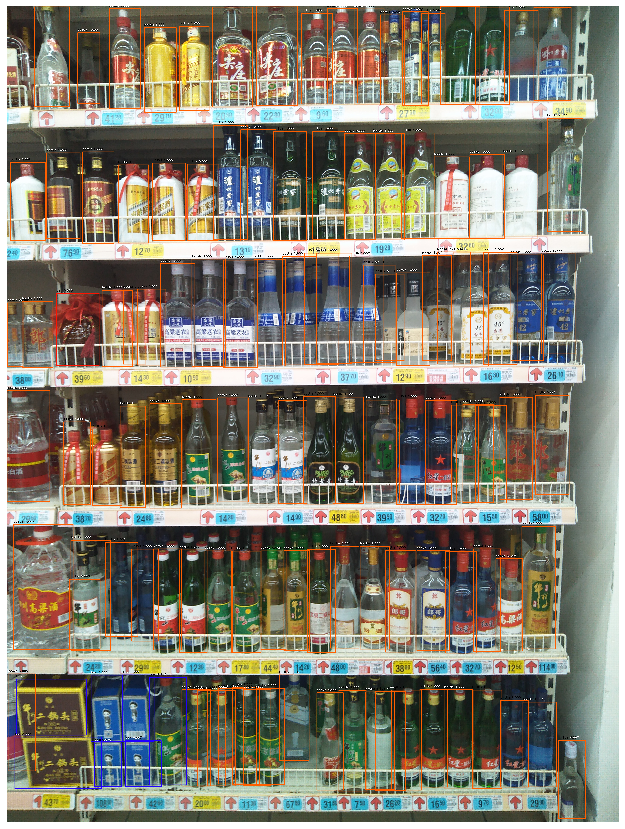

True

In [31]:
# load image
image = read_image_bgr('test_1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

# 保存结果图
cv2.imwrite("test_1_result.jpg", draw)

## 检测抠小图

In [32]:
# load image
image = read_image_bgr('test_1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

idx = 0
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break

    b = box.astype(int)        
    cropped = draw[b[1]:b[3], b[0]:b[2]]
    if cropped is not None:
        cv2.imwrite(f"data/classified_raw/{idx}.jpg", cropped)    
    idx+=1

processing time:  0.12376046180725098
